In [426]:
from research.backtest import max_drawdown

"""
Top-2 Momentum Rotation vs Buy&Hold Benchmark
---------------------------------------------
- Strategy: long top 2 assets by momentum (1M return) or MA strength.
- Benchmark: buy & hold an equal-weight portfolio of ALL assets (or choose one benchmark ticker).

Outputs:
- Equity curves (strategy net & gross, benchmark)
- Summary stats table

Dependencies: pandas, numpy, yfinance, matplotlib
"""

from __future__ import annotations

from dataclasses import dataclass
from typing import List, Literal, Optional, Dict

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt


SignalType = Literal["mom_1m", "ma", "trend_annret_r2"]
WeightingType = Literal["equal", "inv_vol"]


@dataclass(frozen=True)
class Config:
    start: str = "2016-01-01"
    end: Optional[str] = None

    rebalance: str = "W-FRI"      # "D", "W-FRI", "M"
    top_k: int = 2

    signal: SignalType = "mom_1m"
    mom_lookback: int = 21
    ma_lookback: int = 50
    trend_lookback: int = 60
    
    weighting: WeightingType = "equal"
    vol_lookback: int = 20

    fee_bps: float = 2.0

    # Benchmark configuration:
    benchmark_mode: Literal["equal_weight_all", "single_ticker"] = "equal_weight_all"
    benchmark_ticker: Optional[str] = None  # used if benchmark_mode="single_ticker"
        
    # Risk control overlay
    use_trend_filter: bool = True
    trend_ma: int = 200          # e.g., 200d MA for “risk-on”
    
    use_asset_vol_scaling: bool = True
    asset_vol_lookback: int = 20 # realized vol window per asset
    
    max_gross_exposure: float = 1.0  # 1.0 = no leverage; >1 allows leverage
    cash_ticker: Optional[str] = "BIL"


# -------------------------
# Data
# -------------------------

def download_close(tickers: List[str], start: str, end: Optional[str]) -> pd.DataFrame:
    px = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)["Close"]
    if isinstance(px, pd.Series):
        px = px.to_frame()
    px = px.sort_index().ffill().dropna(how="all")
    return px

def fx_ticker_for_ccy(ccy: str) -> str:
    """
    Returns a Yahoo FX ticker that (usually) represents 'CCY per USD' for common CCYs.
    For USD, returns None.
    """
    if ccy == "USD":
        return None
    # Yahoo convention for many currencies: "JPY=X" means USDJPY (JPY per USD)
    return f"{ccy}=X"


def convert_to_usd(prices: pd.DataFrame, ccy_map: dict, start: str, end: str, fx_shift_days: int = 0) -> pd.DataFrame:
    """
    Convert each column in 'prices' from its local currency to USD.

    Assumes fx_ticker 'CCY=X' is 'CCY per USD' (e.g., USDJPY).
    Then USD price = local_price / fx.

    fx_shift_days:
      - 0: use same-date FX close (fine for weekly/monthly)
      - 1: conservative (avoids any accidental close-time alignment issues)
    """
    px = prices.copy().ffill()

    # Collect required FX tickers
    need_ccys = sorted({ccy_map[c] for c in px.columns if ccy_map.get(c, "USD") != "USD"})
    fx_tickers = [fx_ticker_for_ccy(ccy) for ccy in need_ccys]
    fx_tickers = [t for t in fx_tickers if t is not None]

    if fx_tickers:
        fx = download_close(fx_tickers, start, end)
        fx = fx.reindex(px.index).ffill()

        if fx_shift_days != 0:
            fx = fx.shift(fx_shift_days).ffill()

    px_usd = pd.DataFrame(index=px.index, columns=px.columns, dtype=float)

    for col in px.columns:
        ccy = ccy_map.get(col, "USD")
        if ccy == "USD":
            px_usd[col] = px[col]
            continue

        fx_col = fx_ticker_for_ccy(ccy)
        if fx_col not in fx.columns:
            raise ValueError(f"Missing FX series for {ccy} (expected {fx_col}).")

        # USD = local / (CCY per USD)
        px_usd[col] = px[col] / fx[fx_col]

    return px_usd



# -------------------------
# Signals / Scores
# -------------------------

def compute_scores(prices: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    if cfg.signal == "mom_1m":
        return prices.pct_change(cfg.mom_lookback)
    elif cfg.signal == "ma":
        ma = prices.rolling(cfg.ma_lookback).mean()
        return prices / ma - 1.0
    elif cfg.signal == "trend_annret_r2":
        return trend_score_annret_r2(prices, lookback=cfg.trend_lookback)
    else:
        raise ValueError(f"Unknown signal: {cfg.signal}")
    
    
def trend_score_annret_r2(
    prices: pd.DataFrame,
    lookback: int = 25,          # e.g. 6 months ~ 120, 250 for 1y
    ann_factor: int = 252,
) -> pd.DataFrame:
    """
    Trend score = annualised return * R^2 from linear regression of log(price) on time.

    Returns:
      DataFrame (index=prices.index, columns=prices.columns) of scores.
      NaN until lookback is available.

    Method:
      y = log(price)
      x = 0..L-1
      slope b = Cov(x,y)/Var(x)
      R^2 = [Cov(x,y)^2] / [Var(x)*Var(y)]  (equivalent to corr(x,y)^2)
      ann_return = exp(b*ann_factor) - 1
      score = ann_return * R^2
    """
    px = prices.copy()
    px = px.replace([np.inf, -np.inf], np.nan).ffill()

    y = np.log(px)
    L = int(lookback)
    if L < 2:
        raise ValueError("lookback must be >= 2")

    # x = 0..L-1
    x = np.arange(L, dtype=float)
    x_mean = x.mean()
    var_x = ((x - x_mean) ** 2).sum()  # constant

    # rolling sums for y and y^2
    sum_y = y.rolling(L, min_periods=L).sum()
    sum_y2 = (y * y).rolling(L, min_periods=L).sum()

    # rolling sum of x*y: use rolling apply with dot(x, window)
    # (This is the only non-trivial part; still manageable for typical ETF universes.)
    def dot_x(arr: np.ndarray) -> float:
        return float(np.dot(x, arr))

    sum_xy = y.rolling(L, min_periods=L).apply(dot_x, raw=True)

    # Cov(x,y) = sum((x-xm)(y-ym)) = sum(xy) - L*xm*ym
    y_mean = sum_y / L
    cov_xy = sum_xy - L * x_mean * y_mean

    # slope per day
    b = cov_xy / var_x

    # Var(y) over window: E[y^2] - (E[y])^2
    var_y = (sum_y2 / L) - (y_mean ** 2)
    var_y = var_y.clip(lower=0.0)

    # R^2 = cov^2 / (var_x * sum((y-ym)^2))
    # sum((y-ym)^2) = L * var_y
    denom = var_x * (L * var_y)
    r2 = (cov_xy ** 2) / denom
    r2 = r2.clip(lower=0.0, upper=1.0)

    ann_ret = np.exp(b * ann_factor) - 1.0
    score = ann_ret * r2
    return score


def inv_vol_weights(returns: pd.DataFrame, lookback: int) -> pd.DataFrame:
    vol = returns.rolling(lookback).std(ddof=0)
    inv = 1.0 / vol.replace(0, np.nan)
    inv = inv.replace([np.inf, -np.inf], np.nan)
    return inv


# -------------------------
# Weight construction
# -------------------------
def build_strategy_weights(prices: pd.DataFrame, scores: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    reb_scores = scores.resample(cfg.rebalance).last().dropna(how="all")

    rets = prices.pct_change()
    inv = inv_vol_weights(rets, cfg.vol_lookback) if cfg.weighting == "inv_vol" else None

    w_reb = pd.DataFrame(index=reb_scores.index, columns=prices.columns, dtype=float)

    for dt in reb_scores.index:
        s = reb_scores.loc[dt].replace([np.inf, -np.inf], np.nan)
        valid = s.dropna().index.tolist()

        w = pd.Series(0.0, index=prices.columns)

        if len(valid) == 0:
            # if no valid scores (early warmup), keep cash (all zero) -> will become zero return
            w_reb.loc[dt] = w
            continue

        top = s.loc[valid].sort_values(ascending=False).head(cfg.top_k).index.tolist()

        if cfg.weighting == "equal":
            w.loc[top] = 1.0 / len(top)
        else:
            inv_row = inv.loc[dt, top].astype(float)
            if inv_row.isna().all():
                w.loc[top] = 1.0 / len(top)
            else:
                inv_row = inv_row.fillna(inv_row.mean()).clip(lower=0)
                z = inv_row.sum()
                w.loc[top] = (inv_row / z).values if z > 0 and np.isfinite(z) else (1.0 / len(top))

        w_reb.loc[dt] = w

    # expand to daily
    weights = w_reb.reindex(prices.index).ffill().fillna(0.0)
    s = weights.sum(axis=1).replace(0, np.nan)
    weights = weights.div(s, axis=0).fillna(0.0)
    return weights


def build_benchmark_weights(prices: pd.DataFrame, cfg: Config) -> pd.Series:
    """
    Returns daily benchmark weights:
      - equal_weight_all: constant equal weight across all assets
      - single_ticker: 100% in cfg.benchmark_ticker
    """
    cols = prices.columns.tolist()

    if cfg.benchmark_mode == "equal_weight_all":
        w = pd.Series(1.0 / len(cols), index=cols)
        W = pd.DataFrame([w.values] * len(prices.index), index=prices.index, columns=cols)
        return W

    if cfg.benchmark_mode == "single_ticker":
        if not cfg.benchmark_ticker or cfg.benchmark_ticker not in cols:
            raise ValueError("benchmark_ticker must be set and included in tickers when benchmark_mode='single_ticker'.")
        w = pd.Series(0.0, index=cols)
        w[cfg.benchmark_ticker] = 1.0
        W = pd.DataFrame([w.values] * len(prices.index), index=prices.index, columns=cols)
        return W

    raise ValueError(f"Unknown benchmark_mode: {cfg.benchmark_mode}")


# -------------------------
# Backtest
# -------------------------

def backtest(prices: pd.DataFrame, weights: pd.DataFrame, fee_bps: float) -> Dict[str, pd.Series]:
    rets = prices.pct_change().fillna(0.0)

    w_lag = weights.shift(1).fillna(0.0)
    gross = (w_lag * rets).sum(axis=1)

    turnover = (weights - weights.shift(1)).abs().sum(axis=1).fillna(0.0)
    fee = (fee_bps / 10000.0) * turnover
    net = gross - fee

    eq_gross = (1.0 + gross).cumprod()
    eq_net = (1.0 + net).cumprod()

    return {
        "gross_ret": gross,
        "net_ret": net,
        "equity_gross": eq_gross,
        "equity_net": eq_net,
        "turnover": turnover
    }


def perf_stats(equity: pd.Series, daily_ret: pd.Series) -> pd.Series:
    ann = 252.0
    total = equity.iloc[-1] / equity.iloc[0] - 1.0
    n = len(equity)
    ann_ret = (equity.iloc[-1] / equity.iloc[0]) ** (ann / max(n, 1)) - 1.0
    ann_vol = daily_ret.std(ddof=0) * np.sqrt(ann)
    sharpe = np.nan if ann_vol == 0 else (daily_ret.mean() * ann) / ann_vol
    dd = equity / equity.cummax() - 1.0
    mdd = dd.min()
    return pd.Series({
        "Total Return": total,
        "Ann Return (geo)": ann_ret,
        "Ann Vol": ann_vol,
        "Sharpe": sharpe,
        "Max Drawdown": mdd
    })


# -------------------------
# Plot
# -------------------------

def plot_compare(
    strat_eq: pd.Series,
    bench_eq: pd.Series,
    title: str = "Strategy vs Benchmark"
) -> None:
    plt.figure(figsize=(11, 5))
    plt.plot(strat_eq.index, strat_eq.values, label="Strategy (Net)")
    plt.plot(bench_eq.index, bench_eq.values, label="Benchmark (Buy&Hold)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

=== Performance Summary ===
                  Strategy(Net)  Benchmark(BH)
Total Return          12.052930      14.879265
Ann Return (geo)       0.125910       0.136143
Ann Vol                0.142766       0.217247
Sharpe                 0.902397       0.696406
Max Drawdown          -0.455680      -0.537062

=== Avg Turnover (Strategy) ===
0.1385 per day


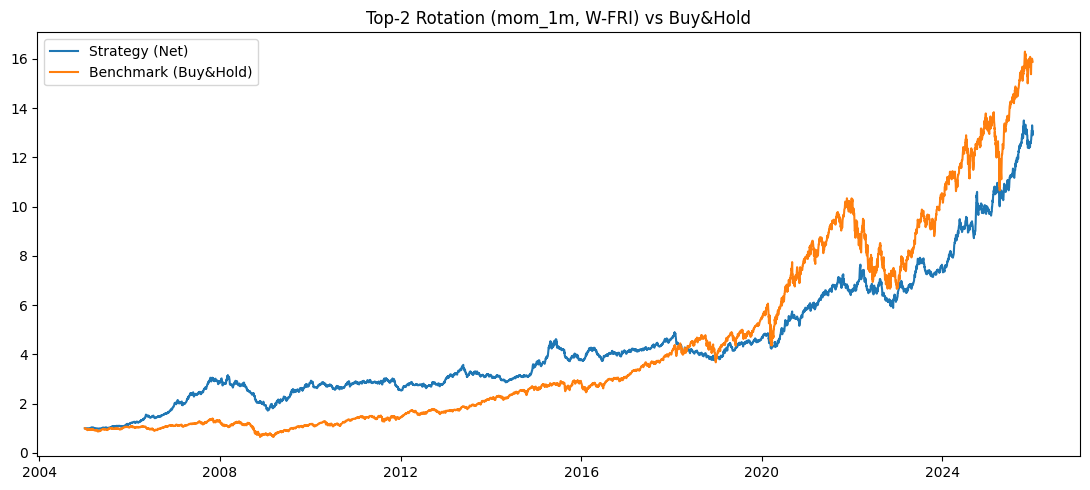

In [431]:
# -------------------------
# Example usage
# -------------------------


# Replace with your 5 ETFs. These are proxies that work on Yahoo.
# tickers = ["DVY", "CHIQ", "IEF", "GLD", "DBB"]
tickers = [
    "000001.SS",  # SSE Composite
    "^HSI",       # Hang Seng Index
    "^N225",      # Nikkei 225
    # "^GSPC",      # S&P 500
    "GLD",        # Gold ETF proxy
    "DBB",        # Base metals ETF proxy (有色) on Yahoo
    "BIL",        # Cash proxy (T-bills ETF)
    '^NDX',
    'IEF',      # 7-10 year treasury bond 
]

CCY = {
    "^GSPC": "USD",
    "^NDX":  "USD",
    "^HSI":  "HKD",
    "^N225": "JPY",
    "000001.SS": "CNY",
}

# (Optional) label helpers
# CASH_TICKER = "BIL"
# METALS_TICKER = "DBB"
start_date = "2005-01-01"
end_date = "2025-12-31"

cfg = Config(
    start=start_date,
    end=end_date,
    rebalance="W-FRI",
    top_k=2,
    signal="mom_1m",         # "mom_1m" or "ma" or 'trend_annret_r2'
    weighting="equal",       # "equal" or "inv_vol"
    fee_bps=2.0,
    # benchmark_mode="equal_weight_all",   # or "single_ticker"
    benchmark_mode='single_ticker',
    benchmark_ticker='^NDX'    # e.g. "IEF" if single_ticker
)

prices = download_close(tickers, cfg.start, cfg.end)
# Convert only the index legs (GLD/IEF/DBC are already USD)
ccy_map = {**CCY, "GLD": "USD", "IEF": "USD", "DBC": "USD"}
prices_usd = convert_to_usd(prices, ccy_map, start_date, end_date, fx_shift_days=0)

# Strategy
scores = compute_scores(prices, cfg)
w_strat = build_strategy_weights(prices, scores, cfg)
res_strat = backtest(prices, w_strat, fee_bps=cfg.fee_bps)

# Benchmark: buy&hold
w_bench = build_benchmark_weights(prices, cfg)
res_bench = backtest(prices, w_bench, fee_bps=0.0)  # benchmark usually shown gross of fees

# Align
eq_s = res_strat["equity_net"]
eq_b = res_bench["equity_gross"]

# Print stats
out = pd.DataFrame({
    "Strategy(Net)": perf_stats(eq_s, res_strat["net_ret"]),
    "Benchmark(BH)": perf_stats(eq_b, res_bench["gross_ret"])
})
print("=== Performance Summary ===")
print(out.to_string())

print("\n=== Avg Turnover (Strategy) ===")
print(f"{float(res_strat['turnover'].mean()):.4f} per day")

plot_compare(eq_s, eq_b, title=f"Top-{cfg.top_k} Rotation ({cfg.signal}, {cfg.rebalance}) vs Buy&Hold")


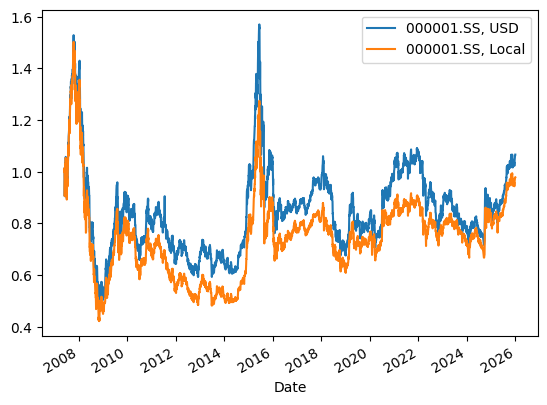

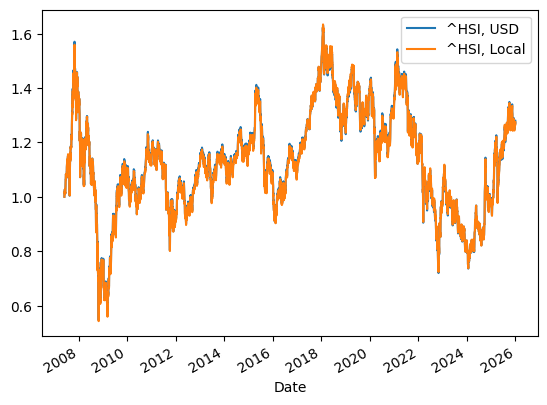

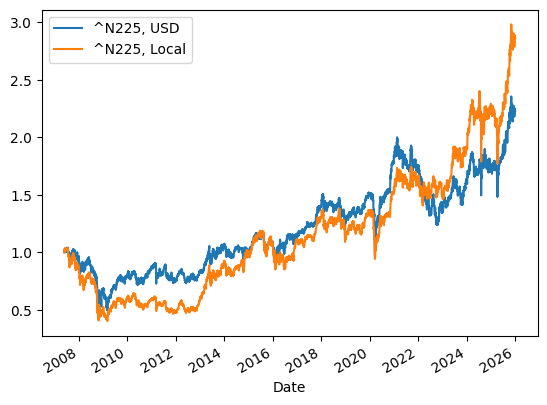

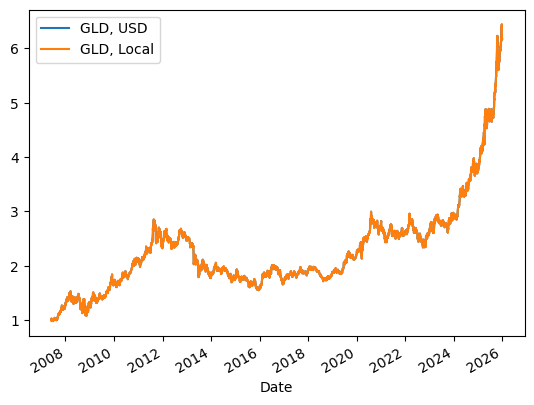

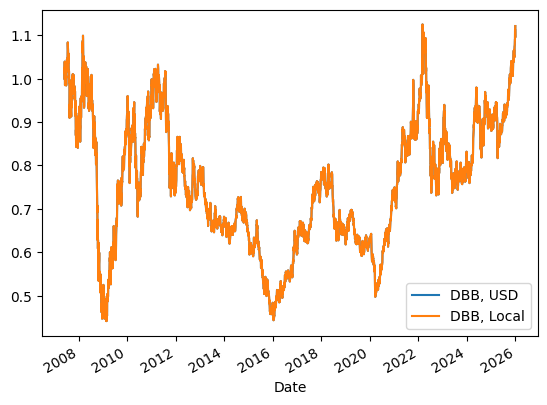

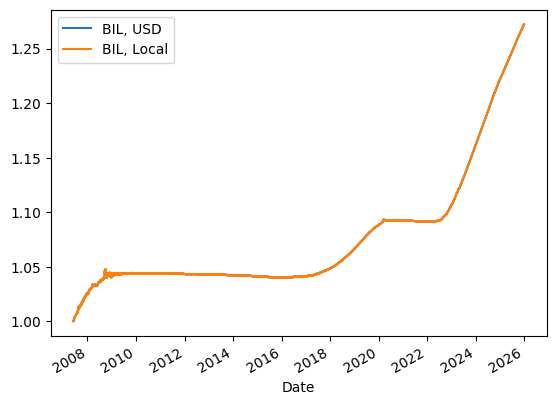

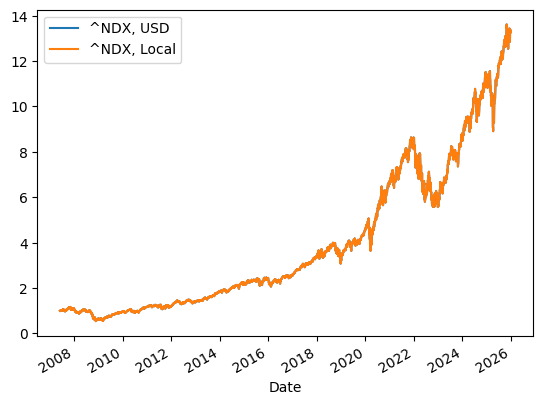

In [418]:
for t in tickers:
    (prices_usd.dropna() / prices_usd.dropna().iloc[0])[t].plot(label=f'{t}, USD')
    (prices.dropna() / prices.dropna().iloc[0])[t].plot(label=f'{t}, Local')
    plt.legend()
    plt.show()

In [376]:
# """
# Extensions: parameter stability + relative performance + sub-period stats
# + rolling excess Sharpe + crisis-only analysis + core+tactical overlay.
# 
# This code assumes you already have these functions from earlier:
# - download_close(tickers, start, end)
# - compute_scores(prices, cfg)
# - build_strategy_weights(prices, scores, cfg)
# - build_benchmark_weights(prices, cfg)
# - backtest(prices, weights, fee_bps)
# - perf_stats(equity, daily_ret)
# 
# If you used my previous script, you can paste this block underneath it.
# """
# 
# from dataclasses import replace
# from typing import Dict, List, Tuple
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# 
# 
# # ============================================================
# # Helpers: relative performance, rolling Sharpe, subperiod stats
# # ============================================================
# 
# def relative_performance(strategy_eq: pd.Series, bench_eq: pd.Series) -> pd.Series:
#     """Relative curve = strategy / benchmark."""
#     aligned = pd.concat([strategy_eq, bench_eq], axis=1).dropna()
#     rel = aligned.iloc[:, 0] / aligned.iloc[:, 1]
#     rel.name = "Strategy / Benchmark"
#     return rel
# 
# def rolling_sharpe(ret: pd.Series, window: int = 252) -> pd.Series:
#     """Rolling annualized Sharpe for a daily return series."""
#     mu = ret.rolling(window).mean()
#     sd = ret.rolling(window).std(ddof=0)
#     out = (mu / sd) * np.sqrt(252)
#     return out.replace([np.inf, -np.inf], np.nan)
# 
# def subperiod_stats(equity: pd.Series, daily_ret: pd.Series, periods: List[Tuple[str, str]]) -> pd.DataFrame:
#     """Compute perf stats by subperiod date ranges (inclusive)."""
#     rows = {}
#     for (a, b) in periods:
#         mask = (equity.index >= pd.to_datetime(a)) & (equity.index <= pd.to_datetime(b))
#         eq = equity.loc[mask]
#         r = daily_ret.loc[mask]
#         if len(eq) < 50:  # too short
#             continue
#         rows[f"{a} to {b}"] = perf_stats(eq, r)
#     return pd.DataFrame(rows).T
# 
# def plot_relative(strategy_eq: pd.Series, bench_eq: pd.Series, title: str = "Relative Performance") -> None:
#     rel = relative_performance(strategy_eq, bench_eq)
#     plt.figure(figsize=(11, 4))
#     plt.plot(rel.index, rel.values)
#     plt.title(title)
#     plt.tight_layout()
#     plt.show()
# 
# def plot_rolling_excess_sharpe(strat_ret: pd.Series, bench_ret: pd.Series, window: int = 252) -> pd.Series:
#     """
#     Rolling Sharpe of excess returns (strategy - benchmark).
#     Returns the series and plots it.
#     """
#     excess = (strat_ret - bench_ret).dropna()
#     rs = rolling_sharpe(excess, window=window)
#     plt.figure(figsize=(11, 4))
#     plt.plot(rs.index, rs.values)
#     plt.axhline(0, linewidth=1)
#     plt.title(f"Rolling Excess Sharpe (window={window})")
#     plt.tight_layout()
#     plt.show()
#     return rs
# 
# 
# # ============================================================
# # Crisis-only analysis
# # ============================================================
# 
# def drawdown(equity: pd.Series) -> pd.Series:
#     return equity / equity.cummax() - 1.0
# 
# def crisis_mask_from_benchmark(bench_eq: pd.Series, dd_threshold: float = -0.20) -> pd.Series:
#     """
#     Define crisis days as when benchmark drawdown <= dd_threshold, e.g. -20%.
#     """
#     dd = drawdown(bench_eq)
#     return (dd <= dd_threshold)
# 
# def crisis_stats(
#     strat_eq: pd.Series, strat_ret: pd.Series,
#     bench_eq: pd.Series, bench_ret: pd.Series,
#     dd_threshold: float = -0.20
# ) -> pd.DataFrame:
#     """
#     Compute stats on crisis days only (as defined by benchmark drawdown <= threshold).
#     """
#     mask = crisis_mask_from_benchmark(bench_eq, dd_threshold=dd_threshold)
#     # Align
#     df = pd.concat([strat_eq, strat_ret, bench_eq, bench_ret, mask.rename("crisis")], axis=1).dropna()
#     df.columns = ["strat_eq", "strat_ret", "bench_eq", "bench_ret", "crisis"]
# 
#     df_c = df[df["crisis"]]
#     if len(df_c) < 50:
#         raise ValueError("Too few crisis days under current threshold; loosen dd_threshold (e.g., -0.15)")
# 
#     out = pd.DataFrame({
#         "Strategy (crisis days)": perf_stats(df_c["strat_eq"], df_c["strat_ret"]),
#         "Benchmark (crisis days)": perf_stats(df_c["bench_eq"], df_c["bench_ret"]),
#     })
#     return out
# 
# def plot_crisis_segments(strat_eq: pd.Series, bench_eq: pd.Series, dd_threshold: float = -0.20) -> None:
#     """
#     Plot equity curves but highlight crisis regions (benchmark DD <= threshold).
#     """
#     mask = crisis_mask_from_benchmark(bench_eq, dd_threshold=dd_threshold).reindex(strat_eq.index).fillna(False)
#     aligned = pd.concat([strat_eq.rename("strat"), bench_eq.rename("bench")], axis=1).dropna()
#     mask = mask.loc[aligned.index]
# 
#     plt.figure(figsize=(11, 5))
#     plt.plot(aligned.index, aligned["strat"].values, label="Strategy (Net)")
#     plt.plot(aligned.index, aligned["bench"].values, label="Benchmark (BH)")
#     # highlight crisis
#     y0, y1 = plt.ylim()
#     in_crisis = False
#     start = None
#     for dt, v in mask.items():
#         if v and not in_crisis:
#             in_crisis = True
#             start = dt
#         if not v and in_crisis:
#             plt.axvspan(start, dt, alpha=0.2)
#             in_crisis = False
#     if in_crisis and start is not None:
#         plt.axvspan(start, mask.index[-1], alpha=0.2)
# 
#     plt.title(f"Equity Curves with Crisis Highlight (Benchmark DD <= {dd_threshold:.0%})")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()
# 
# 
# # ============================================================
# # Parameter stability: grid test + plots
# # ============================================================
# 
# def run_once(prices: pd.DataFrame, cfg, bench_cfg) -> Dict[str, object]:
#     """
#     Run strategy + benchmark, return key series and stats.
#     """
#     scores = compute_scores(prices, cfg)
#     w_strat = build_strategy_weights(prices, scores, cfg)
#     res_strat = backtest(prices, w_strat, fee_bps=cfg.fee_bps)
# 
#     w_bench = build_benchmark_weights(prices, bench_cfg)
#     res_bench = backtest(prices, w_bench, fee_bps=0.0)
# 
#     eq_s = res_strat["equity_net"].rename("Strategy")
#     eq_b = res_bench["equity_gross"].rename("Benchmark")
#     r_s = res_strat["net_ret"].rename("strat_ret")
#     r_b = res_bench["gross_ret"].rename("bench_ret")
# 
#     stats_tbl = pd.DataFrame({
#         "Strategy(Net)": perf_stats(eq_s, r_s),
#         "Benchmark(BH)": perf_stats(eq_b, r_b),
#     })
# 
#     return {
#         "eq_s": eq_s, "eq_b": eq_b,
#         "r_s": r_s, "r_b": r_b,
#         "res_strat": res_strat, "res_bench": res_bench,
#         "stats": stats_tbl
#     }
# 
# def param_stability_grid(
#     prices: pd.DataFrame,
#     base_cfg,
#     bench_cfg,
#     mom_lookbacks=(21, 42, 63),
#     rebalances=("W-FRI", "M"),
#     top_ks=(1, 2, 3),
# ) -> pd.DataFrame:
#     """
#     Grid over parameters. Returns a tidy table with key metrics for each config.
#     """
#     rows = []
#     for lb in mom_lookbacks:
#         for rb in rebalances:
#             for k in top_ks:
#                 cfg = replace(base_cfg, signal="mom_1m", mom_lookback=lb, rebalance=rb, top_k=k)
#                 out = run_once(prices, cfg, bench_cfg)
#                 s = out["stats"]["Strategy(Net)"]
#                 rows.append({
#                     "signal": "mom_1m",
#                     "mom_lookback": lb,
#                     "rebalance": rb,
#                     "top_k": k,
#                     "CAGR": float(s["Ann Return (geo)"]),
#                     "Vol": float(s["Ann Vol"]),
#                     "Sharpe": float(s["Sharpe"]),
#                     "MaxDD": float(s["Max Drawdown"]),
#                     "AvgTurnover": float(out["res_strat"]["turnover"].mean()),
#                 })
#     df = pd.DataFrame(rows).sort_values(["rebalance", "mom_lookback", "top_k"]).reset_index(drop=True)
#     return df
# 
# def plot_grid_heatmap(df: pd.DataFrame, value_col: str = "Sharpe", title: str = "Parameter Stability Heatmap") -> None:
#     """
#     Heatmap-like plot without seaborn.
#     We fix:
#       x-axis: top_k
#       y-axis: mom_lookback
#       separate panels by rebalance
#     """
#     rebalances = sorted(df["rebalance"].unique())
#     topks = sorted(df["top_k"].unique())
#     lookbacks = sorted(df["mom_lookback"].unique())
# 
#     n = len(rebalances)
#     plt.figure(figsize=(6*n, 4.8))
#     for i, rb in enumerate(rebalances, 1):
#         ax = plt.subplot(1, n, i)
#         sub = df[df["rebalance"] == rb].copy()
# 
#         mat = np.full((len(lookbacks), len(topks)), np.nan)
#         for r_i, lb in enumerate(lookbacks):
#             for c_i, k in enumerate(topks):
#                 v = sub[(sub["mom_lookback"] == lb) & (sub["top_k"] == k)][value_col]
#                 mat[r_i, c_i] = float(v.iloc[0]) if len(v) else np.nan
# 
#         im = ax.imshow(mat, aspect="auto", interpolation="nearest")
#         ax.set_xticks(range(len(topks)))
#         ax.set_xticklabels(topks)
#         ax.set_yticks(range(len(lookbacks)))
#         ax.set_yticklabels(lookbacks)
#         ax.set_xlabel("top_k")
#         ax.set_ylabel("mom_lookback")
#         ax.set_title(f"{value_col} | rebalance={rb}")
#         plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
# 
#     plt.suptitle(title)
#     plt.tight_layout()
#     plt.show()
# 
# def plot_equity_bundle(results: Dict[str, Dict[str, object]], title: str = "Equity Curves (Strategy)") -> None:
#     """
#     results: dict label -> run_once output
#     """
#     plt.figure(figsize=(11, 5))
#     for label, out in results.items():
#         plt.plot(out["eq_s"].index, out["eq_s"].values, label=label)
#     plt.title(title)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()
# 
# 
# # ============================================================
# # Core + Tactical Overlay
# # ============================================================
# 
# def build_core_weights(prices: pd.DataFrame, core_mode: str, cash_ticker: str) -> pd.DataFrame:
#     """
#     Core portfolio (strategic) examples:
#       - "equal_risky": equal-weight all non-cash assets
#       - "60_40_cash": 60% equal-weight risky + 40% cash
#     """
#     cols = prices.columns.tolist()
#     risky = [c for c in cols if c != cash_ticker]
# 
#     if core_mode == "equal_risky":
#         w = pd.Series(0.0, index=cols)
#         w[risky] = 1.0 / len(risky)
#         W = pd.DataFrame([w.values] * len(prices), index=prices.index, columns=cols)
#         return W
# 
#     if core_mode == "60_40_cash":
#         w = pd.Series(0.0, index=cols)
#         w[risky] = 0.60 / len(risky)
#         w[cash_ticker] = 0.40
#         W = pd.DataFrame([w.values] * len(prices), index=prices.index, columns=cols)
#         return W
# 
#     raise ValueError("Unknown core_mode")
# 
# def combine_core_tactical(core_w: pd.DataFrame, tactical_w: pd.DataFrame, alpha: float = 0.5, max_tilt: float = 0.20) -> pd.DataFrame:
#     """
#     Final weights = (1-alpha)*core + alpha*tactical, with per-asset tilt cap.
#     max_tilt caps |w_final - w_core| per asset.
#     """
#     core_w, tactical_w = core_w.align(tactical_w, join="inner", axis=0)
#     w = (1 - alpha) * core_w + alpha * tactical_w
# 
#     # tilt cap
#     tilt = (w - core_w).clip(lower=-max_tilt, upper=max_tilt)
#     w = core_w + tilt
# 
#     # renormalize
#     s = w.sum(axis=1).replace(0, np.nan)
#     w = w.div(s, axis=0).fillna(0.0)
#     return w
# 
# 
# # ============================================================
# # How to run (example)
# # ============================================================
# 
# # Example usage (adapt to your objects):
# 
# tickers = ["000001.SS","^HSI","^N225","^GSPC","GLD","DBB","BIL"]
# prices = download_close(tickers, cfg.start, cfg.end)
# 
# base_cfg = cfg  # your Config instance from earlier
# bench_cfg = replace(cfg, benchmark_mode="equal_weight_all")  # excludes cash? see below
# 
# # IMPORTANT: if you want benchmark to exclude cash, make sure your build_benchmark_weights() does so.
# # If your current build_benchmark_weights equal-weights ALL columns, then benchmark includes cash too.
# # Common choice: benchmark = equal-weight risky assets only (exclude BIL).
# #
# # 1) Parameter stability grid
# df_grid = param_stability_grid(prices, base_cfg, bench_cfg,
#                                mom_lookbacks=(10, 20, 40, 60),
#                                rebalances=("W-FRI","M"),
#                                top_ks=(1,2,3))
# print(df_grid)
# plot_grid_heatmap(df_grid, value_col="Sharpe")
# # plot_grid_heatmap(df_grid, value_col="CAGR")
# # plot_grid_heatmap(df_grid, value_col="MaxDD")
# 
# # 2) Relative performance + subperiod stats for ONE chosen config
# out = run_once(prices, replace(base_cfg, signal="mom_1m", mom_lookback=20, rebalance="W-FRI", top_k=2), bench_cfg)
# plot_relative(out["eq_s"], out["eq_b"], title="Relative: Strategy / Benchmark")
# 
# periods = [("2004-01-01","2010-12-31"), ("2011-01-01","2019-12-31"), ("2020-01-01","2099-12-31")]
# sp = subperiod_stats(out["eq_s"], out["r_s"], periods)
# bp = subperiod_stats(out["eq_b"], out["r_b"], periods)
# print("\nStrategy subperiod stats:\n", sp)
# print("\nBenchmark subperiod stats:\n", bp)
# 
# # 3) Rolling excess Sharpe
# plot_rolling_excess_sharpe(out["r_s"], out["r_b"], window=252)
# 
# # 4) Crisis-only analysis (benchmark DD <= -20%)
# print("\nCrisis-only stats:\n", crisis_stats(out["eq_s"], out["r_s"], out["eq_b"], out["r_b"], dd_threshold=-0.15))
# plot_crisis_segments(out["eq_s"], out["eq_b"], dd_threshold=-0.15)
# 
# # 5) Core + Tactical Overlay
# cash = "BIL"
# core_w = build_core_weights(prices, core_mode="equal_risky", cash_ticker=cash)
# # tactical rotation weights from your rotation strategy:
# scores = compute_scores(prices, cfg)
# tactical_w = build_strategy_weights(prices, scores, cfg)
# w_overlay = combine_core_tactical(core_w, tactical_w, alpha=0.5, max_tilt=0.20)
# res_overlay = backtest(prices, w_overlay, fee_bps=base_cfg.fee_bps)
# print("\nOverlay stats:\n", perf_stats(res_overlay["equity_net"], res_overlay["net_ret"]))
# plt.figure(figsize=(11,5))
# plt.plot(res_overlay["equity_net"].index, res_overlay["equity_net"].values, label="Core+Tactical (Net)")
# plt.plot(out["eq_s"].index, out["eq_s"].values, label="Pure Tactical (Net)", alpha=0.7)
# plt.plot(out["eq_b"].index, out["eq_b"].values, label="Benchmark", alpha=0.7)
# plt.legend(); plt.title("Core+Tactical Overlay vs Tactical vs Benchmark"); plt.tight_layout(); plt.show()


Date
2005   -0.000563
2006    1.245348
2007    0.763456
2008   -0.333179
2009    0.675687
2010    0.011978
2011   -0.280640
2012    0.134935
2013   -0.138807
2014    0.270982
2015    0.074456
2016    0.082241
2017    0.148022
2018   -0.191493
2019    0.069750
2020   -0.064074
2021    0.210337
2022    0.112774
2023   -0.135131
2024    0.013638
2025    0.205959
dtype: float64


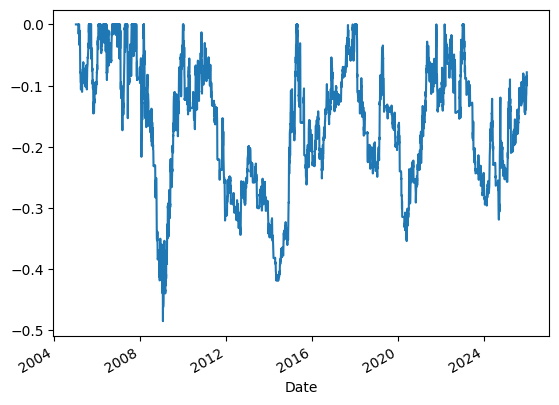

In [398]:
def _drawdown_from_equity(eq: pd.Series) -> pd.Series:
    """Drawdown series from equity curve."""
    if eq is None or len(eq) == 0:
        return pd.Series(dtype=float)
    peak = eq.cummax()
    return eq / peak - 1.0

def _yearly_returns_from_returns(r: pd.Series) -> pd.Series:
    """
    Calendar-year compounded returns from periodic returns r.
    Works for H-day returns too (compounds all observations within each year).
    """
    r = r.dropna()
    if len(r) == 0:
        return pd.Series(dtype=float)
    # group by calendar year and compound
    return (1.0 + r).groupby(r.index.year).prod() - 1.0

_drawdown_from_equity(eq_s).plot()
print(_yearly_returns_from_returns(res_strat["net_ret"]))

## Volatility Targeting

In [399]:
def portfolio_returns(prices: pd.DataFrame, weights: pd.DataFrame) -> pd.Series:
    """
    Daily portfolio simple returns.
    Assumes weights are applied with 1-day lag (no lookahead).
    """
    rets = prices.pct_change().fillna(0.0)
    w_lag = weights.shift(1).fillna(0.0)
    return (w_lag * rets).sum(axis=1)

def apply_costs(
    weights: pd.DataFrame,
    cost_bps: float = 2.0
) -> pd.Series:
    """
    Transaction cost based on portfolio turnover.
    """
    turnover = weights.diff().abs().sum(axis=1)
    cost = turnover * (cost_bps / 1e4)
    return cost

In [400]:
def vol_target_returns(
    ret: pd.Series,
    target_vol: float = 0.10,
    vol_lookback: int = 20,
    ann_factor: int = 252,
    max_leverage: float = 2.0,
) -> pd.DataFrame:
    rv = ret.rolling(vol_lookback, min_periods=vol_lookback).std() * np.sqrt(ann_factor)
    scale = (target_vol / rv).clip(0.0, max_leverage)
    scale = scale.shift(1).fillna(0.0)  # no lookahead
    ret_vt = scale * ret
    eq_vt = (1 + ret_vt).cumprod()
    return pd.DataFrame({"scale": scale, "ret_vt": ret_vt, "eq_vt": eq_vt})

r = res_strat['net_ret']

vt = vol_target_returns(r, target_vol=0.10, vol_lookback=20, max_leverage=2)

eq_vt = vt["eq_vt"]          # new equity curve (vol-targeted)
ret_vt = vt["ret_vt"]        # new returns
scale = vt["scale"]          # exposure multiplier

Base vol (ann): 0.19736665328195108
VT vol (ann):   0.12828361988280196
Base MaxDD: 0.0
VT   MaxDD: 0.0


Total Return        1.845275
Ann Return (geo)    0.049584
Ann Vol             0.128272
Sharpe              0.441483
Max Drawdown       -0.339583
dtype: float64

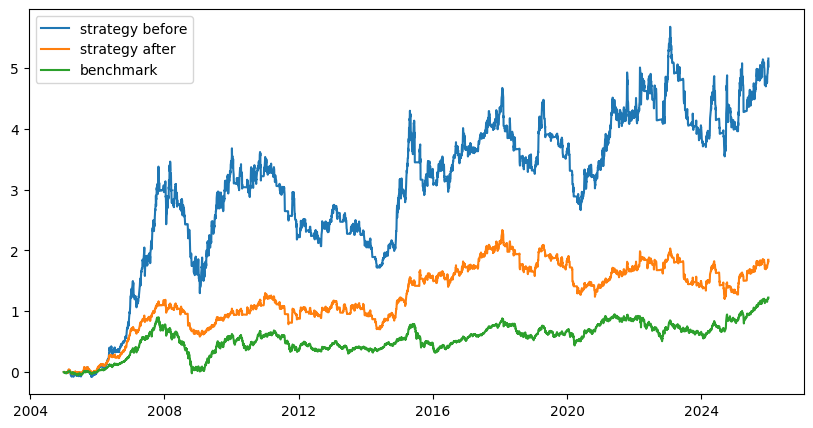

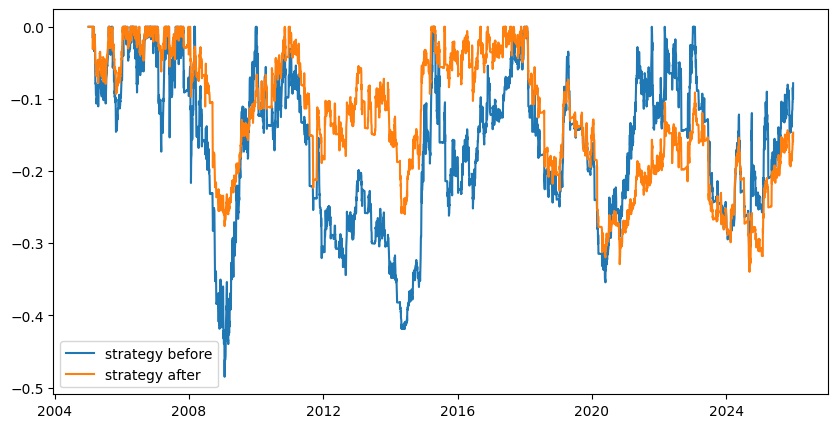

In [401]:
print("Base vol (ann):", r.std()*np.sqrt(252))
print("VT vol (ann):  ", ret_vt.std()*np.sqrt(252))

print("Base MaxDD:", max_drawdown((1+r).cumprod()))
print("VT   MaxDD:", max_drawdown(eq_vt))

plt.figure(figsize=(10, 5))
plt.plot(eq_s - 1, label='strategy before')
plt.plot(eq_vt - 1, label='strategy after')
plt.plot(eq_b - 1, label='benchmark')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(_drawdown_from_equity(eq_s), label='strategy before')
plt.plot(_drawdown_from_equity(eq_vt), label='strategy after')
plt.legend()

perf_stats(eq_vt, ret_vt)

In [402]:
rv = ret_vt.rolling(20).std() * np.sqrt(252)
rv.describe()


count    5426.000000
mean        0.116639
std         0.053258
min         0.000000
25%         0.088530
50%         0.109575
75%         0.137626
max         0.383246
Name: ret_vt, dtype: float64

## Vol targeting + Portfolio

In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# Copper/Oil Regime Backtest Suite (Multi-Market)
# - Single binary regime from Copper/Oil
# - Test any market price series (US, China, HK, etc.)
# - Supports: long-only, long/short, hysteresis, vol-targeting
# ============================================================

# ----------------------------
# Helpers
# ----------------------------
def rolling_zscore(x: pd.Series, w: int) -> pd.Series:
    mu = x.rolling(w, min_periods=w).mean()
    sd = x.rolling(w, min_periods=w).std()
    return (x - mu) / sd

# def perf_stats(ret: pd.Series, ann_factor: int = 252) -> dict:
#     ret = ret.dropna()
#     if len(ret) == 0:
#         return {"ann_ret": np.nan, "ann_vol": np.nan, "sharpe": np.nan, "max_dd": np.nan, "n": 0}
#     ann_ret = ret.mean() * ann_factor
#     ann_vol = ret.std() * np.sqrt(ann_factor)
#     sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
#     eq = (1 + ret).cumprod()
#     max_dd = (eq / eq.cummax() - 1).min()
#     return {"ann_ret": float(ann_ret), "ann_vol": float(ann_vol), "sharpe": float(sharpe), "max_dd": float(max_dd), "n": int(len(ret))}

def _ensure_price_series(s: pd.Series, name: str) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    s = s.replace([np.inf, -np.inf], np.nan)
    s = s.where(s > 0)  # prices must be positive for log ops
    s.name = name
    return s

def plot_rolling_sharpe(
    df_bt: pd.DataFrame,
    market_name: str,
    window: int = 252,
    ann_factor: int = 252,
    show_buy_hold: bool = True,
):
    """
    df_bt must contain:
      - 'strategy_ret' : strategy simple returns
      - 'mkt_ret'      : market simple returns
    """
    # ============================================================
    # Rolling Sharpe (multi-market compatible)
    # - Computes rolling Sharpe for strategy and buy&hold
    # - Plots one chart per market (no subplots, per your preference)
    # ============================================================
    
    def rolling_sharpe(ret: pd.Series, window: int = 252, ann_factor: int = 252) -> pd.Series:
        """
        Rolling Sharpe = (mean * ann_factor) / (std * sqrt(ann_factor))
        Uses simple returns. Returns a Series aligned to the original index.
        """
        ret = pd.to_numeric(ret, errors="coerce")
        mu = ret.rolling(window, min_periods=window).mean() * ann_factor
        sd = ret.rolling(window, min_periods=window).std() * np.sqrt(ann_factor)
        return (mu / sd).replace([np.inf, -np.inf], np.nan)
    
    rs_strat = rolling_sharpe(df_bt["strategy_ret"], window=window, ann_factor=ann_factor)
    rs_bh = rolling_sharpe(df_bt["mkt_ret"], window=window, ann_factor=ann_factor)

    plt.figure(figsize=(10, 4))
    plt.plot(rs_strat.index, rs_strat.values, label=f"Strategy rolling Sharpe ({window}d)")
    if show_buy_hold:
        plt.plot(rs_bh.index, rs_bh.values, label=f"Buy&Hold rolling Sharpe ({window}d)", alpha=0.7)
    plt.axhline(0.0, linewidth=1)
    plt.title(f"{market_name} — Rolling Sharpe")
    plt.ylabel("Sharpe (annualized)")
    plt.legend()
    plt.show()

def build_co_regime(
    copper: pd.Series,
    oil: pd.Series,
    z_window: int = 252,
    upper: float | None = None,
    lower: float | None = None,
) -> pd.DataFrame:
    """
    Build Copper/Oil regime:
      - If upper/lower not provided => simple threshold at 0: regime=1[z>0]
      - If upper/lower provided => hysteresis regime
    Returns DataFrame with columns: co_ratio, log_co, z_co, regime
    """
    copper = _ensure_price_series(copper, "copper")
    oil = _ensure_price_series(oil, "oil")

    df = pd.concat([copper, oil], axis=1).dropna().copy()
    df["co_ratio"] = df["copper"] / df["oil"]
    df["log_co"] = np.log(df["co_ratio"])
    df["z_co"] = rolling_zscore(df["log_co"], z_window)

    if upper is None or lower is None:
        df["regime"] = (df["z_co"] > 0).astype(int)
    else:
        # Hysteresis: switch ON only above upper, switch OFF only below lower
        state = []
        cur = 0
        for z in df["z_co"].values:
            if np.isnan(z):
                state.append(cur)
                continue
            if cur == 0 and z > upper:
                cur = 1
            elif cur == 1 and z < lower:
                cur = 0
            state.append(cur)
        df["regime"] = pd.Series(state, index=df.index).astype(int)

    return df


# ----------------------------
# Core Backtest Function
# ----------------------------
def run_co_regime_backtest(
    market_price: pd.Series,
    copper: pd.Series,
    oil: pd.Series,
    *,
    market_name: str = "market",
    z_window: int = 252,
    hysteresis: bool = False,
    upper: float = 0.25,
    lower: float = -0.25,
    mode: str = "long_only",        # "long_only" or "long_short"
    vol_target: float | None = None, # e.g. 0.12 annual; None disables
    vol_lookback: int = 20,
    max_leverage: float = 2.0,
    ann_factor: int = 252,
    plot: bool = True,
) -> dict:
    """
    Backtest Copper/Oil regime strategy on a chosen market.

    Inputs
    - market_price: price series for the market you test (e.g., SPY, CSI300, HSI)
    - copper, oil: price series for copper and oil (same frequency, alignable)
    - mode:
        "long_only": position = 1 if regime ON else 0
        "long_short": position = 1 if regime ON else -1
    - vol_target: if set, scale position by (vol_target / realized_vol), capped by max_leverage

    Output dict contains:
      - stats table (strategy + buy&hold)
      - dataframe with positions, returns, equity
    """
    market_price = _ensure_price_series(market_price, market_name)

    # Build regime on overlapping dates (with copper/oil)
    if hysteresis:
        reg = build_co_regime(copper, oil, z_window=z_window, upper=upper, lower=lower)
    else:
        reg = build_co_regime(copper, oil, z_window=z_window, upper=None, lower=None)

    # Align market to regime dates
    d = pd.concat([market_price, reg[["regime", "z_co"]]], axis=1).dropna().copy()

    # Simple returns for backtest
    d["mkt_ret"] = d[market_name].pct_change()

    # Base position
    if mode.lower() == "long_only":
        base_pos = d["regime"].astype(float)               # 1 or 0
    elif mode.lower() == "long_short":
        base_pos = (2 * d["regime"] - 1).astype(float)     # 1 or -1
    else:
        raise ValueError("mode must be 'long_only' or 'long_short'")

    # Optional vol targeting
    if vol_target is not None:
        rv = d["mkt_ret"].rolling(vol_lookback, min_periods=vol_lookback).std() * np.sqrt(ann_factor)
        scale = (vol_target / rv).clip(lower=0.0, upper=max_leverage)
        d["scale"] = scale
        d["position"] = (base_pos * scale).shift(1).fillna(0.0)
    else:
        d["scale"] = 1.0
        d["position"] = base_pos.shift(1).fillna(0.0)

    # Strategy returns and equity
    d["strategy_ret"] = d["position"] * d["mkt_ret"]
    d["eq_strategy"] = (1 + d["strategy_ret"]).cumprod()
    d["eq_bh"] = (1 + d["mkt_ret"]).cumprod()
    d["mkt_norm"] = d[market_name] / d[market_name].iloc[0]
    
    # -- TODO: --
    def perf_stats(ret: pd.Series, ann_factor: int = 252) -> dict:
        ret = ret.dropna()
        if len(ret) == 0:
            return {"ann_ret": np.nan, "ann_vol": np.nan, "sharpe": np.nan, "max_dd": np.nan, "n": 0}
        ann_ret = ret.mean() * ann_factor
        ann_vol = ret.std() * np.sqrt(ann_factor)
        sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
        eq = (1 + ret).cumprod()
        max_dd = (eq / eq.cummax() - 1).min()
        return {"ann_ret": float(ann_ret), "ann_vol": float(ann_vol), "sharpe": float(sharpe), "max_dd": float(max_dd), "n": int(len(ret))}

    # Stats
    stats = {
        "market": market_name,
        "mode": mode,
        "hysteresis": hysteresis,
        "z_window": z_window,
        "vol_target": vol_target,
        "strategy": perf_stats(d["strategy_ret"], ann_factor=ann_factor),
        "buy_hold": perf_stats(d["mkt_ret"], ann_factor=ann_factor),
        "avg_exposure": float(d["position"].abs().mean()),
        "pct_in_market": float((d["position"] != 0).mean()),
        "regime_on_share": float(d["regime"].mean()),
    }

    if plot:
        title = f"{market_name} | {mode} | hyst={hysteresis} | vol_target={vol_target}"
        plt.figure(figsize=(10,5))
        plt.plot(d.index, d["eq_strategy"], label="Strategy")
        plt.plot(d.index, d["eq_bh"], label="Buy&Hold", alpha=0.7)
        plt.legend()
        plt.title(title)
        plt.show()

        plt.figure(figsize=(10,2))
        plt.plot(d.index, d["position"], label="Position")
        plt.title(f"Position — {market_name}")
        plt.show()

    return {"stats": stats, "df": d}


def compute_hysteresis_regime(z: pd.Series, upper: float, lower: float) -> pd.Series:
    """
    Hysteresis regime:
    - Turn ON when z > upper
    - Turn OFF when z < lower
    - Otherwise keep previous state
    Returns int series {0,1}.
    """
    z = z.copy()
    regime = pd.Series(index=z.index, dtype="float64")

    state = 0
    for t, val in z.items():
        if np.isnan(val):
            regime.loc[t] = np.nan
            continue

        if state == 0 and val > upper:
            state = 1
        elif state == 1 and val < lower:
            state = 0
        regime.loc[t] = state

    return regime.astype("float64")


def plot_co_regime_shading(
    df: pd.DataFrame,
    market_col: str,
    *,
    copper_col: str = "copper",
    oil_col: str = "oil",
    z_window: int = 252,
    upper: float = 0.5,
    lower: float = -0.5,
    use_log_price: bool = False,
    title: str | None = None,
):
    """
    Plot 2: Copper/Oil z-score + regime shading + market price (or log price).
    Preconditions:
      - df index is datetime
      - df contains copper, oil, and market_col
    """
    d = df[[copper_col, oil_col, market_col]].dropna().sort_index().copy()

    # Copper/Oil ratio and z-score
    d["co_ratio"] = d[copper_col] / d[oil_col]
    d["co_log"] = np.log(d["co_ratio"])
    mu = d["co_log"].rolling(z_window, min_periods=z_window).mean()
    sd = d["co_log"].rolling(z_window, min_periods=z_window).std()
    d["co_z"] = (d["co_log"] - mu) / sd

    # Hysteresis regime on z-score
    d["regime"] = compute_hysteresis_regime(d["co_z"], upper=upper, lower=lower)
    d["regime"] = d["regime"].ffill().fillna(0).astype(int)

    # Market series to plot
    m = d[market_col]
    m_plot = np.log(m) if use_log_price else m

    # ---- Plot
    fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    # Helper: shade ON regions
    def shade_on(ax, idx, reg):
        reg = reg.reindex(idx).fillna(0).astype(int)
        # shade where reg == 1
        in_on = False
        start = None
        for t, r in reg.items():
            if (not in_on) and r == 1:
                in_on = True
                start = t
            elif in_on and r == 0:
                ax.axvspan(start, t, alpha=0.12)
                in_on = False
        if in_on:
            ax.axvspan(start, idx[-1], alpha=0.12)

    # Top: z-score
    axes[0].plot(d.index, d["co_z"], linewidth=1.2)
    axes[0].axhline(upper, linestyle="--", linewidth=1.0)
    axes[0].axhline(lower, linestyle="--", linewidth=1.0)
    axes[0].axhline(0.0, linestyle=":", linewidth=1.0)
    shade_on(axes[0], d.index, d["regime"])
    axes[0].set_ylabel(f"zscore(log(C/O), {z_window}d)")
    axes[0].set_title(title or f"Copper/Oil Regime (upper={upper}, lower={lower}) + {market_col}")

    # Bottom: market price
    axes[1].plot(d.index, m_plot, linewidth=1.2)
    shade_on(axes[1], d.index, d["regime"])
    axes[1].set_ylabel("log(price)" if use_log_price else "price")
    axes[1].set_xlabel("Date")

    plt.tight_layout()
    plt.show()

    return d  # returns the aligned data incl. co_z and regime for later use

/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_34853/188366167.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(['HG=F', 'CL=F', '^HSI'], start=start_date, end=end_date)['Close'].dropna()
[*********************100%***********************]  3 of 3 completed
/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_34853/188366167.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start=start_date, end=end_date)['Close'].squeeze()
[*********************100%***********************]  1 of 1 completed
/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_34853/188366167.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ss001 = yf.download('000001.SS', start=start_date, end=end_date)['Close'].squeeze()
[*********************100%***********************]  1 of 1 completed
/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipyk

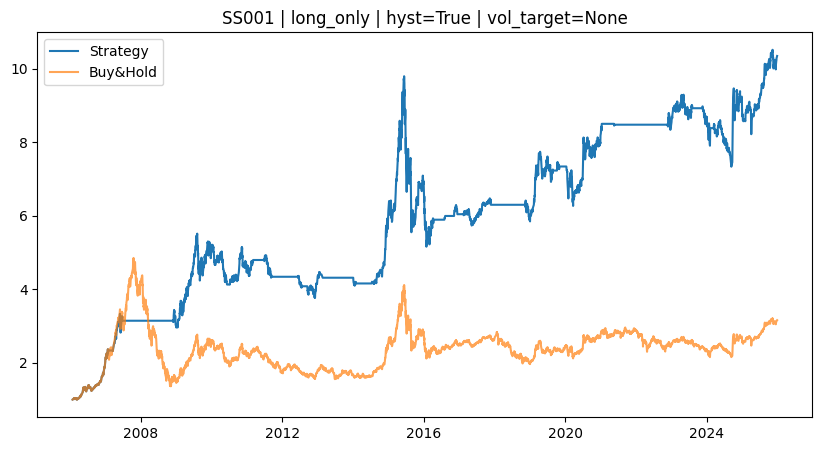

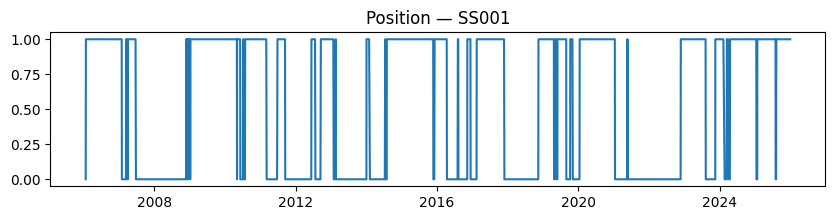

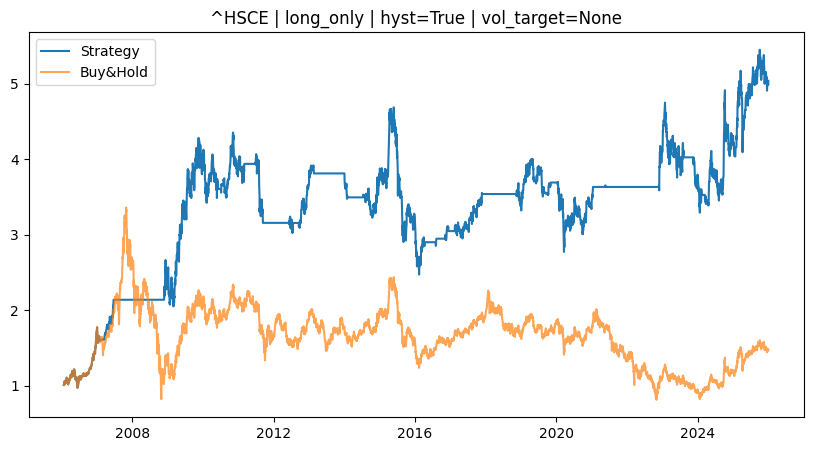

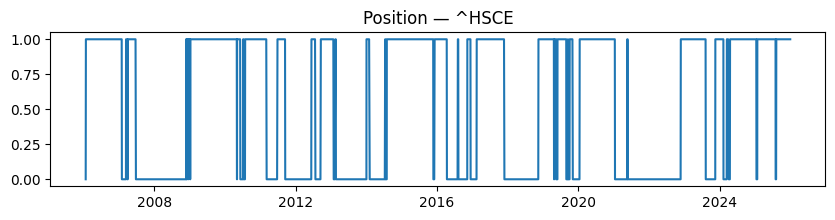

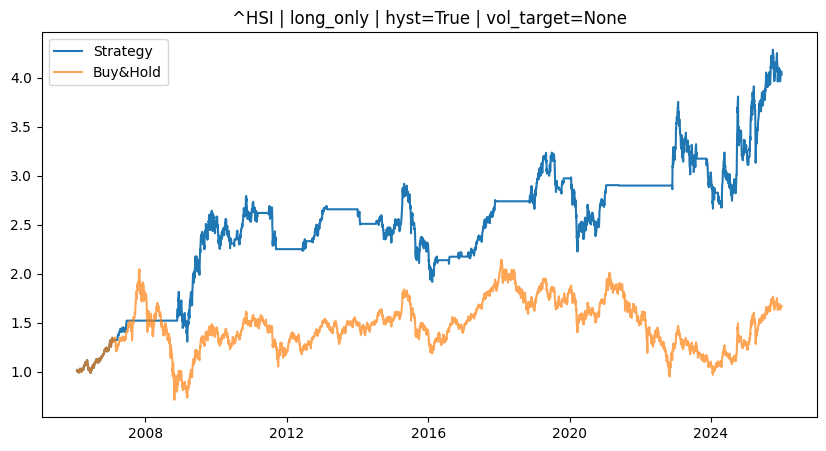

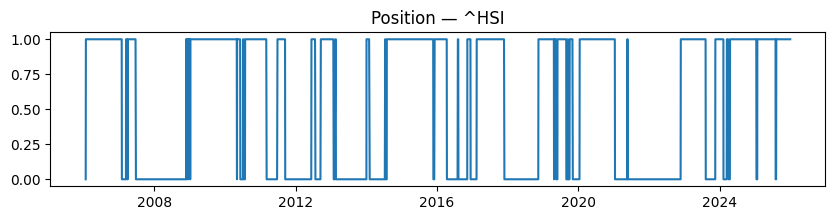

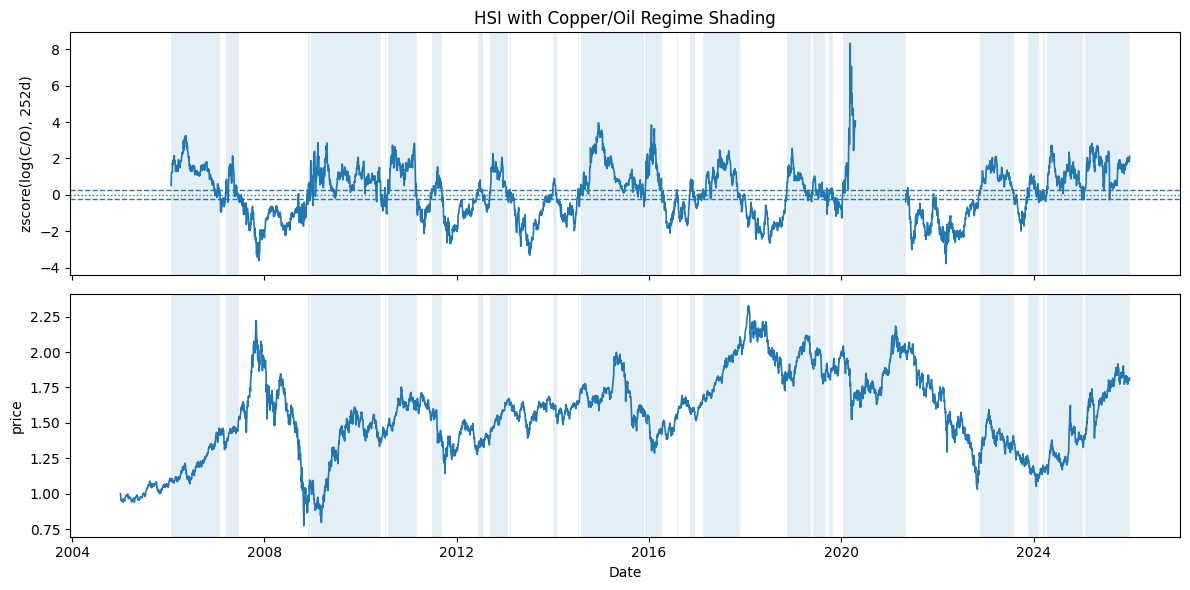

{'market': '^HSI',
 'mode': 'long_only',
 'hysteresis': True,
 'z_window': 252,
 'vol_target': None,
 'strategy': {'ann_ret': 0.08781698628815189,
  'ann_vol': 0.16689995910667876,
  'sharpe': 0.526165415247473,
  'max_dd': -0.3434582065013351,
  'n': 4783},
 'buy_hold': {'ann_ret': 0.05726664296569928,
  'ann_vol': 0.24560379444101735,
  'sharpe': 0.2331667680299299,
  'max_dd': -0.6518186042408534,
  'n': 4783},
 'avg_exposure': 0.5635451505016722,
 'pct_in_market': 0.5635451505016722,
 'regime_on_share': 0.5637541806020067}

In [252]:
# start_date = '2000-01-01'
# end_date = '2025-12-24'

df = yf.download(['HG=F', 'CL=F', '^HSI'], start=start_date, end=end_date)['Close'].dropna()
df.columns = ['oil', 'copper', '^HSI']
df = df / df.iloc[0]

sp500 = yf.download('^GSPC', start=start_date, end=end_date)['Close'].squeeze()
ss001 = yf.download('000001.SS', start=start_date, end=end_date)['Close'].squeeze()
hsce = yf.download('^HSCE', start=start_date, end=end_date)['Close'].squeeze()
hsi = yf.download('^HSI', start=start_date, end=end_date)['Close'].squeeze()
n225 = yf.download('^N225', start=start_date, end=end_date)['Close'].squeeze()

markets = {
    '^HSI': hsi,
    '^HSCE': hsce,
    'SS001': ss001,
}

outs = {}

# Run one market with plots:
for market in ['SS001', '^HSCE', '^HSI']:
    out = run_co_regime_backtest(
        market_price=markets[market],
        copper=df["copper"],
        oil=df["oil"],
        market_name=market,
        mode="long_only",
        hysteresis=True,
        upper=0.25,
        lower=-0.25,
        # vol_target=0.12,  # try vol targeting to reduce LS volatility
        plot=True,
    )
    
    outs[market] = out

# For HSI
plot_df = plot_co_regime_shading(
    df,
    market_col="^HSI",
    z_window=252,
    upper=0.25,
    lower=-0.25,
    use_log_price=False,
    title="HSI with Copper/Oil Regime Shading",
)

outs['^HSI']["stats"]

In [264]:
portfolios = pd.DataFrame()
portfolios['multi-indices momentum strategy'] = eq_vt

for asset in outs:
    portfolios[f'{asset} copper/oil strategy'] = outs[asset]['df']['eq_strategy']

n_assets = len(portfolios.columns)
weights = [0.9] + [0.1 / (n_assets - 1) for _ in range(n_assets - 1)]

<Axes: xlabel='Date'>

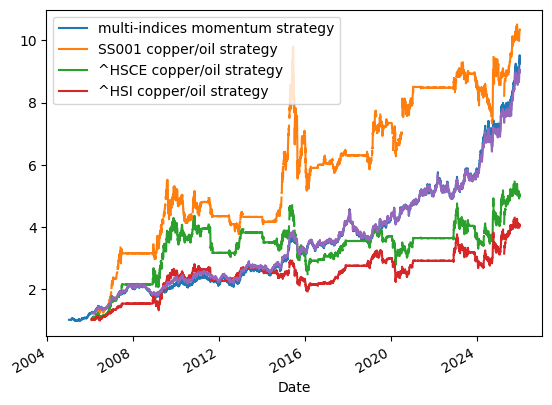

In [265]:
cum_ret = (portfolios.dropna() * weights).sum(axis=1)
pct_ret = cum_ret.pct_change().fillna(0)
portfolios.plot()
cum_ret.plot()

Total Return        6.453523
Ann Return (geo)    0.117131
Ann Vol             0.116762
Sharpe              1.007273
Max Drawdown       -0.208309
dtype: float64

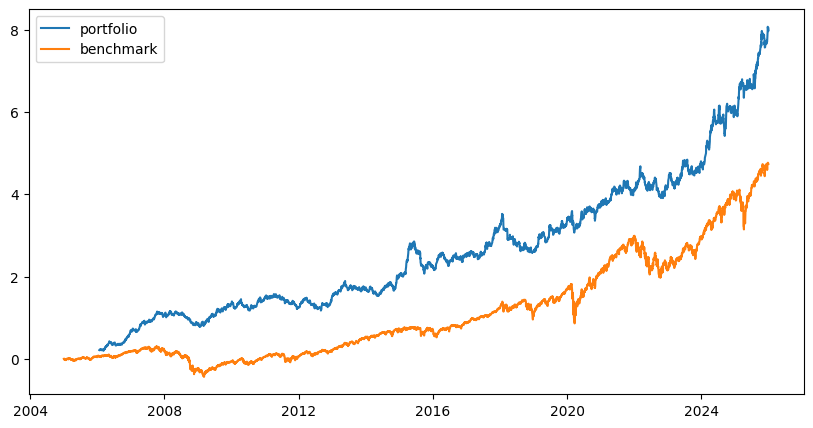

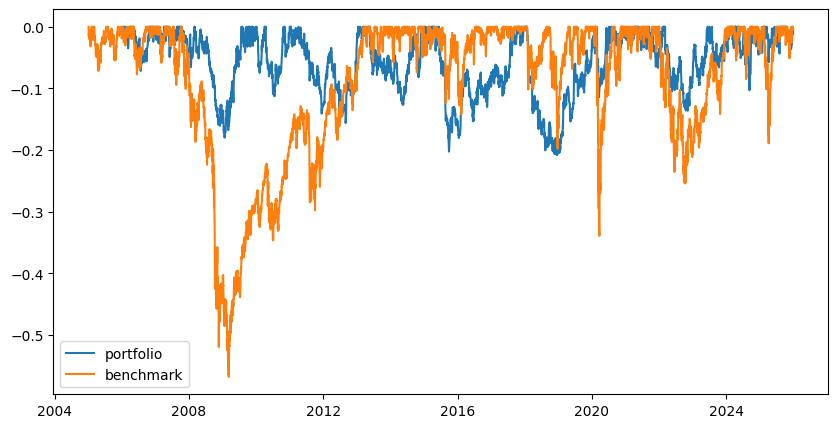

In [266]:
plt.figure(figsize=(10, 5))
plt.plot(cum_ret - 1, label='portfolio')
plt.plot(eq_b - 1, label='benchmark')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(_drawdown_from_equity(cum_ret), label='portfolio')
plt.plot(_drawdown_from_equity(eq_b), label='benchmark')
plt.legend()

perf_stats(cum_ret, pct_ret)

##  Industry ETFs

In [270]:
us_etfs = pd.read_csv('/Users/henrywzh/Desktop/us_sectors.csv')
us_etfs

,Sector,Ticker,Key Industries Included
0,Technology,XLK,"Semiconductors, Software, Hardware"
1,Health Care,XLV,"Pharma, Biotech, Medical Devices"
2,Financials,XLF,"Banks, Insurance, Asset Management"
3,Consumer Discretionary,XLY,"Amazon, Tesla, Retail, Restaurants"
4,Communication Services,XLC,"Meta, Alphabet, Netflix, Telecom"
5,Industrials,XLI,"Aerospace, Defense, Machinery, Rail"
6,Consumer Staples,XLP,"Beverages, Household Goods, Food"
7,Energy,XLE,"Oil & Gas Exploration, Equipment"
8,Utilities,XLU,"Electric, Water, and Gas Utilities"
9,Real Estate,XLRE,REITs (excluding Towers/Datacenters sometimes)


In [296]:
def download_close_one(ticker: str, start: str, end: Optional[str]) -> pd.Series:
    px = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)["Close"]

    # px can be Series or DataFrame depending on yfinance behavior
    if isinstance(px, pd.DataFrame):
        if px.shape[1] != 1:
            raise ValueError(f"Expected single column for {ticker}, got {px.shape[1]} columns.")
        px = px.iloc[:, 0]

    px = px.sort_index().ffill().dropna()
    px.name = ticker
    return px


def build_static_equal_weights(prices: pd.DataFrame) -> pd.DataFrame:
    cols = prices.columns.tolist()
    w = pd.Series(1.0 / len(cols), index=cols)
    W = pd.DataFrame([w.values] * len(prices.index), index=prices.index, columns=cols)
    return W

def plot_equity_curves(
    eq_strategy: pd.Series,
    eq_avg: pd.Series,
    eq_benchmark: Optional[pd.Series] = None,
    title: str = "Equity Curves"
) -> None:
    plt.figure(figsize=(11, 5))
    plt.plot(eq_strategy.index, eq_strategy.values, label="Strategy (Net)")
    plt.plot(eq_avg.index, eq_avg.values, label="Avg-Weighted (EW Buy&Hold)", alpha=0.8)

    if eq_benchmark is not None:
        plt.plot(eq_benchmark.index, eq_benchmark.values, label="Benchmark (Index)", alpha=0.8)

    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [319]:

# -------------------------
# Example usage
# -------------------------


# Replace with your 5 ETFs. These are proxies that work on Yahoo.
# tickers = ["DVY", "CHIQ", "IEF", "GLD", "DBB"]
tickers = us_etfs['Ticker'].tolist()
benchmark_ticker = "^GSPC"

start_date = "2005-01-01"
end_date = "2025-12-31"

cfg = Config(
    start=start_date,
    end=end_date,
    rebalance="W-FRI",
    top_k=2,
    signal="ma",         # "mom_1m" or "ma"
    weighting="equal",       # "equal" or "inv_vol"
    fee_bps=2.0,
    benchmark_mode="equal_weight_all",   # or "single_ticker"
    # benchmark_mode='single_ticker',
    # benchmark_ticker='^GSPC'    # e.g. "IEF" if single_ticker
)

In [ ]:
prices_u = download_close(tickers, cfg.start, cfg.end)

                  Strategy(Net)  AvgWeighted(EW)  Benchmark(Index)
Total Return           7.617082         5.601411          4.736923
Ann Return (geo)       0.108218         0.094219          0.086916
Ann Vol                0.190585         0.163643          0.191475
Sharpe                 0.634773         0.632395          0.531313
Max Drawdown          -0.488122        -0.448991         -0.567754


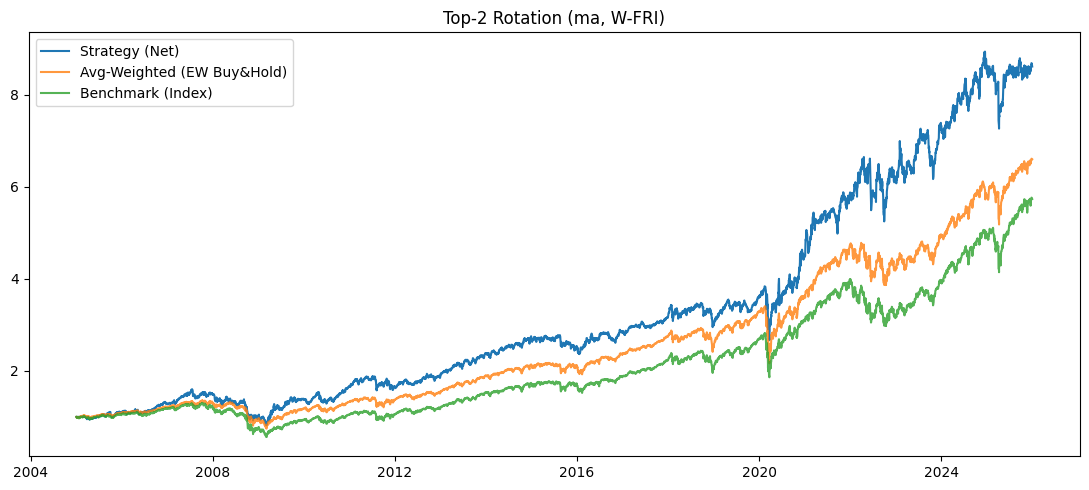

In [320]:
# Strategy
scores = compute_scores(prices_u, cfg)
w_strat = build_strategy_weights(prices_u, scores, cfg)
res_strat = backtest(prices_u, w_strat, fee_bps=cfg.fee_bps)
eq_s = res_strat["equity_net"]

# Avg-weight baseline (static EW buy&hold on universe)
w_avg = build_static_equal_weights(prices_u)
res_avg = backtest(prices_u, w_avg, fee_bps=0.0)
eq_avg = res_avg["equity_gross"]

# Optional benchmark (single index, separate series)
eq_bmk = None
if benchmark_ticker:
    bmk = download_close_one(benchmark_ticker, cfg.start, cfg.end)
    bmk_ret = bmk.pct_change().fillna(0.0)
    eq_bmk = (1.0 + bmk_ret).cumprod()

# Stats table (strategy vs avg baseline, and benchmark if present)
stats = {
    "Strategy(Net)": perf_stats(eq_s, res_strat["net_ret"]),
    "AvgWeighted(EW)": perf_stats(eq_avg, res_avg["gross_ret"]),
}
if eq_bmk is not None:
    stats["Benchmark(Index)"] = perf_stats(eq_bmk, bmk_ret)

out = pd.DataFrame(stats)
print(out.to_string())

plot_equity_curves(
    eq_strategy=eq_s,
    eq_avg=eq_avg,
    eq_benchmark=eq_bmk,
    title=f"Top-{cfg.top_k} Rotation ({cfg.signal}, {cfg.rebalance})"
)